In [51]:
import os
import numpy as np
import pandas as pd



import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
def import_datasets(imgpath, dfpath, train_size, valid_size, img_size, batch_size):
    """
    Import the label dataset and create the train, validation, and, test set.

    Parameters:
    imgpath (str): A string containing the path to the folder with images.
    dfpath (str): A string containing the path to the csv with labels.
    train_size (float): The portion depicting the training size.
    valid_size (float): The portion depicting the validation size.
    img_size (tuples): The size of the image in a tuple.
    batch_size (int): The batch size of the data generator.

    Returns:
    train (object): Training batches of images.
    val (object): Validation batches of images.
    test (object): Test batches of images.
    """

    generator = ImageDataGenerator()
    datasets = []

    # Import the csv from path.
    df = pd.read_csv(dfpath)

    # Encode a label of pizzas without labeled toppings.
    df["plain"] = 0
    df["image_name"] = df["image_name"].apply(lambda x: os.path.join(imgpath, x))
    df.loc[df.iloc[:, 1:-1].max(axis=1) == 0, "plain"] = 1

    # Split the data in training and validation.
    train_df, dummy_df = train_test_split(
        df, train_size=train_size, shuffle=True, random_state=7
    )
    valid_df, test_df = train_test_split(
        dummy_df, train_size=valid_size, shuffle=True, random_state=7
    )

    # Use the ImageDataGenerator from Keras to create batch data.
    for dataset in [train_df, valid_df, test_df]:
        data_generator = generator.flow_from_dataframe(
            dataset,
            x_col="image_name",
            y_col=df.columns[1:],
            target_size=img_size,
            batch_size=batch_size,
            shuffle=True,
            seed=7,
            class_mode="raw",
        )
        datasets.append(data_generator)
    train, val, test = datasets

    return train, val, test, df


train, val, test, df = import_datasets(
    imgpath="data\pizza_data\images",
    dfpath="data\pizza_data\labels.csv",
    train_size=0.8,
    valid_size=0.5,
    img_size=(1080, 1080),
    batch_size=30,
)

df

Found 7370 validated image filenames.
Found 921 validated image filenames.
Found 922 validated image filenames.


,image_name,pepperoni,bacon,mushrooms,onions,peppers,black_olives,tomatoes,spinach,fresh_basil,arugula,broccoli,corn,pineapple,plain
0,data\pizza_data\images\00001.jpg,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,data\pizza_data\images\00002.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,data\pizza_data\images\00003.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,data\pizza_data\images\00004.jpg,0,0,0,1,1,0,0,0,0,0,0,0,0,0
4,data\pizza_data\images\00005.jpg,1,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9208,data\pizza_data\images\09209.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9209,data\pizza_data\images\09210.jpg,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9210,data\pizza_data\images\09211.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9211,data\pizza_data\images\09212.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1


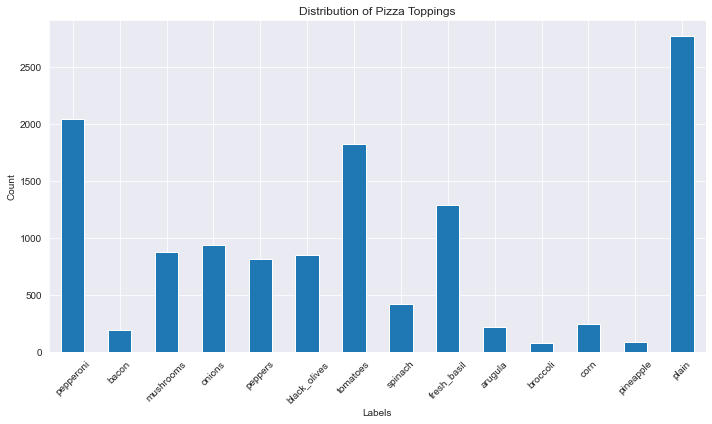

In [34]:
# Calculate the count of occurrences of each label
label_counts = df.drop(columns="image_name").sum()

# Plotting the distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind="bar")
plt.title("Distribution of Pizza Toppings")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
df['toppings'] = df.drop(columns = ['image_name', 'plain']).apply(lambda x: 'Plain' if sum(x) == 0 else ', '.join(df.columns[1:-1][np.where(x)[0]]), axis = 1)
df['toppings'].value_counts()

Plain                                         2767
pepperoni                                     1309
fresh_basil                                    751
tomatoes                                       587
mushrooms                                      304
                                              ... 
pepperoni, bacon, pineapple                      1
spinach, arugula, broccoli                       1
black_olives, tomatoes, fresh_basil, corn        1
pepperoni, mushrooms, onions, black_olives       1
pepperoni, black_olives, tomatoes, corn          1
Name: toppings, Length: 286, dtype: int64

In [46]:
df.drop(columns = ['image_name', 'plain', 'toppings']).sum(axis = 1).value_counts()

1    3984
0    2767
2    1752
3     526
4     143
5      38
6       3
dtype: int64

In [43]:
print(f"Standard deviation of toppings is: {df.drop(columns = ['image_name', 'plain', 'toppings']).sum(axis = 1).std()}")
print(f"Mean of toppings is: {df.drop(columns = ['image_name', 'plain', 'toppings']).sum(axis = 1).mean()}")

Standard deviation of toppings is: 0.9633710794282162
Mean of toppings is: 1.0687072614783457


In [56]:
p_i = np.array((df.drop(columns = ['image_name', 'plain', 'toppings']).sum(axis = 0)/len(df)).tolist())
efdid = sum(p_i*((np.log(p_i)-np.log(1/len(p_i)))**2))
efdid

0.6868645634166795

In [57]:
sum(p_i*((np.log(p_i*len(p_i)))**2))

0.6868645634166792

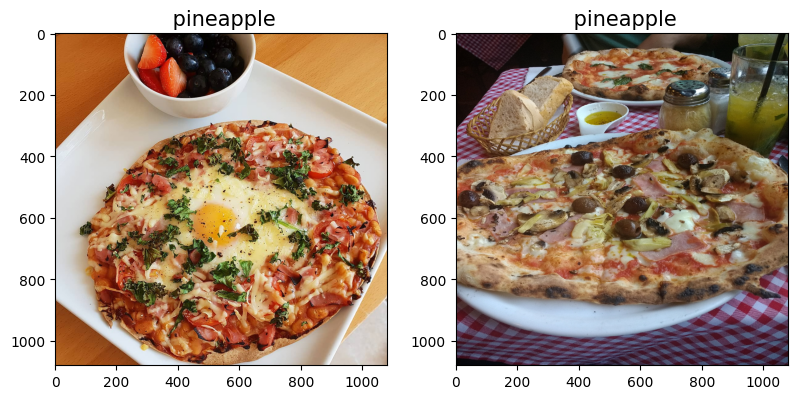

In [9]:
def display_samples(img, classes, num_images):
    images, labels = next(img)
    plt.figure(figsize=(25, 25))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        label = labels[i]
        title = ""
        for j in range(len(label)):
            value = label[j]
            if value == 1:
                title = title + " " + classes[j]
        plt.imshow(image)
        plt.title(title, fontsize=15)
    plt.show()


display_samples(train, df.columns, 2)

In [15]:
train

In [21]:
images, labels = next(train)
images[0].shape

(1080, 1080, 3)

# Test

In [66]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time
from tqdm import tqdm
from itertools import product
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary
import torch
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models

from sklearn.model_selection import train_test_split

# Check for GPU availability
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [210]:
def set_seed(seed=7):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)

    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Numpy RNG
    np.random.seed(seed)

    # OS RNG
    os.environ["PYTHONHASHSEED"] = str(seed)


def worker_init_fn(worker_id):
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)


set_seed(7)

In [211]:
# Hyperparameters
batch_size = 30
dataset_size = 5000  # Reduced dataset size for quicker training

epochs = 20
learning_rate = 0.4

In [58]:
# Import the csv from path.
label_path = "data\pizza_data\imageLabels.txt"
column_path = "data\pizza_data\categories.txt"
image_path = "data\pizza_data\images"

df = pd.read_csv(label_path, sep="  ", header=None)
df.columns = open(column_path, "r").read().split("\n")[:-1]
classes = len(open(column_path, "r").read().split("\n")[:-1]) + 1
open(column_path, "r").close()


# Encode a label of pizzas without labeled toppings.
df["plain"] = 0
df["image_name"] = df.apply(
    lambda x: os.path.join(image_path, str(x.name + 1).zfill(5) + ".jpg"), axis=1
)
df.loc[df.iloc[:, 0:-1].max(axis=1) == 0, "plain"] = 1

# Split the data in training and validation.
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=7)
train_df

C:\Users\woute\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Pepperoni,Bacon,Mushrooms,Onions,Peppers,Black olives,Tomatoes,Spinach,Fresh basil,Arugula,Broccoli,Corn,Pineapple,plain,image_name
2091,0,1,0,1,0,0,1,0,0,0,0,0,0,0,data\pizza_data\images\02092.jpg
7311,0,0,0,0,0,1,0,0,0,0,0,0,0,0,data\pizza_data\images\07312.jpg
2855,0,0,1,0,0,0,1,0,1,0,0,0,0,0,data\pizza_data\images\02856.jpg
8371,0,0,0,0,0,0,0,0,1,0,0,0,0,0,data\pizza_data\images\08372.jpg
4000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data\pizza_data\images\04001.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,0,1,0,0,0,0,0,0,1,0,0,0,0,0,data\pizza_data\images\01373.jpg
919,0,0,0,1,0,0,0,0,0,0,0,0,0,0,data\pizza_data\images\00920.jpg
4307,0,0,0,0,0,0,1,0,0,0,0,0,0,0,data\pizza_data\images\04308.jpg
5699,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data\pizza_data\images\05700.jpg


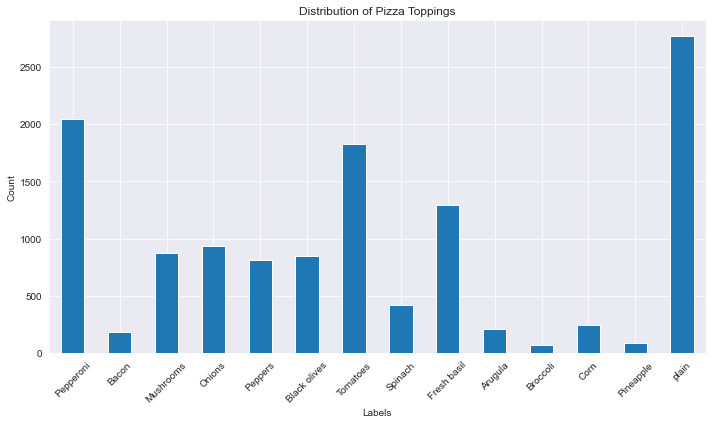

In [75]:
# Calculate the count of occurrences of each label
label_counts = df.drop(columns="image_name").sum()

# Plotting the distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind="bar")
plt.title("Distribution of Pizza Toppings")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [76]:
df.drop(columns="image_name").sum()

Pepperoni       2044
Bacon            187
Mushrooms        875
Onions           933
Peppers          816
Black olives     851
Tomatoes        1822
Spinach          419
Fresh basil     1289
Arugula          213
Broccoli          73
Corn             241
Pineapple         83
plain           2767
dtype: int64

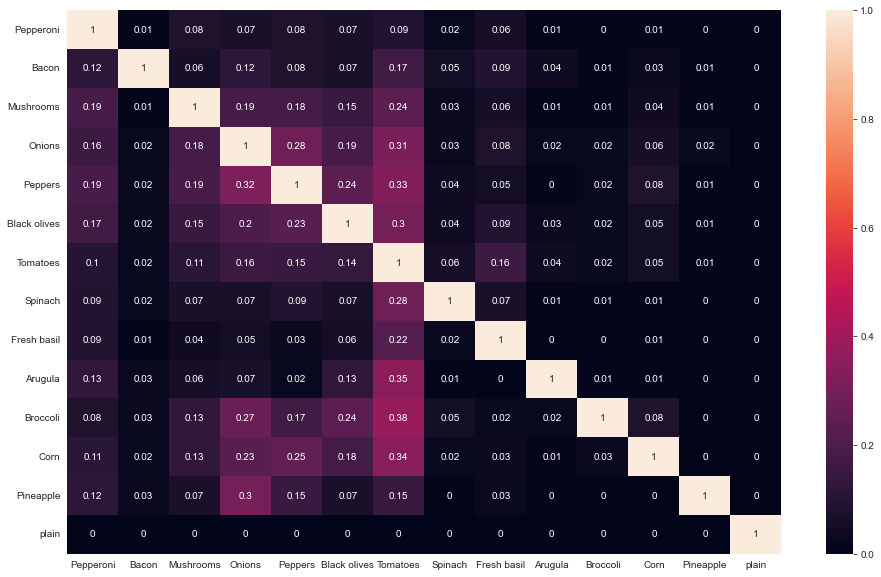

In [77]:
import seaborn as sns
balance_df = train_df.drop(columns="image_name")
lst= []
for label in train_df.columns[:-1]:
    res_lst = balance_df[balance_df[label]==1].sum()/balance_df[train_df[label]==1].sum().max()
    lst.append([round(value, 2) for value in res_lst.tolist()])

plt.figure(figsize=(16, 10)) 
ax = sns.heatmap(lst, annot = True)
ax.tick_params(axis = 'y', labelrotation = 0)
ax.set_xticklabels(balance_df.columns)
ax.set_yticklabels(balance_df.columns);

In [78]:
from scipy.optimize import nnls
mults = nnls(np.array(lst).T, np.repeat(700, len(lst)))
mults

(array([201.23416944, 578.32726312, 289.50861014,   0.        ,
         73.14235169, 109.06056738,   0.        , 505.04546507,
        441.10452039, 514.08655181, 550.58903042, 501.87279006,
        644.14086462, 700.        ]),
 522.3368750954143)

In [79]:
res_arr= np.zeros(len(lst))
for i in range(0, len(lst)):
    res_arr += mults[0][i]*np.array(lst)[i]
    
res_arr

array([ 686.61220373,  662.69265301,  636.31556507,  734.43647189,
        597.3611675 ,  620.82935914, 1137.6316504 ,  605.48974993,
        616.81648229,  566.47985031,  588.1589514 ,  602.76919837,
        654.64125255,  700.        ])

In [80]:
mults_df = pd.DataFrame(mults[0].round(), index = balance_df.columns)
mults_df

,0
Pepperoni,201.0
Bacon,578.0
Mushrooms,290.0
Onions,0.0
Peppers,73.0
Black olives,109.0
Tomatoes,0.0
Spinach,505.0
Fresh basil,441.0
Arugula,514.0


In [81]:
indices = []
for label in train_df.columns[:-1]:
    indices += int(mults_df.loc[label,0]//len(train_df[train_df[label] == 1].index))*train_df[train_df[label] == 1].index.tolist()
    indices += random.sample(train_df[train_df[label] == 1].index.tolist(), int(mults_df.loc[label,0]%len(train_df[train_df[label] == 1].index)))
    
indices

[1071,
 106,
 461,
 3137,
 6406,
 6283,
 2839,
 477,
 3765,
 3831,
 6677,
 6818,
 3140,
 6629,
 3785,
 3719,
 2380,
 8054,
 7859,
 3882,
 3777,
 1308,
 8167,
 5747,
 4,
 9092,
 3837,
 6745,
 5177,
 1341,
 6991,
 9029,
 6673,
 955,
 1933,
 5823,
 5053,
 4103,
 2318,
 3803,
 4602,
 858,
 1449,
 1647,
 9149,
 1272,
 3807,
 8444,
 3599,
 6110,
 5579,
 6231,
 7721,
 3902,
 4222,
 3603,
 683,
 1365,
 3859,
 9166,
 3735,
 6060,
 1752,
 3614,
 5334,
 720,
 2996,
 2382,
 3818,
 6789,
 2727,
 970,
 2929,
 3776,
 6909,
 2256,
 4280,
 6270,
 1002,
 3764,
 5622,
 6641,
 428,
 3576,
 2501,
 5596,
 827,
 8325,
 3557,
 8692,
 7019,
 4502,
 8376,
 4099,
 5286,
 3526,
 4183,
 7216,
 3786,
 3660,
 3782,
 3683,
 3843,
 1780,
 1073,
 3727,
 6468,
 5381,
 7553,
 8342,
 997,
 1121,
 7713,
 3728,
 111,
 379,
 1299,
 4584,
 3672,
 1844,
 5500,
 3746,
 614,
 6274,
 7046,
 7965,
 4893,
 7328,
 6307,
 8215,
 3615,
 5372,
 5326,
 5362,
 6812,
 3596,
 6537,
 915,
 3694,
 7678,
 6318,
 3529,
 7167,
 6831,
 5192,
 19

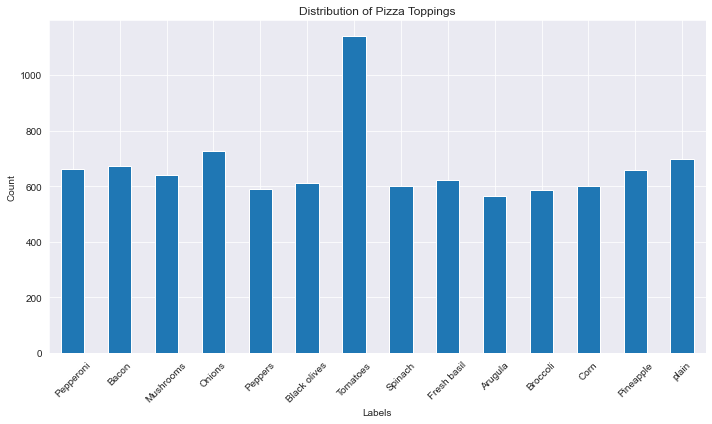

In [82]:
# Plotting the distribution
plt.figure(figsize=(10, 6))
train_df.loc[indices].drop(columns = 'image_name').sum().plot(kind="bar")
plt.title("Distribution of Pizza Toppings")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [83]:
p_i = np.array((train_df.drop(columns = ['image_name', 'plain']).loc[indices].sum(axis = 0)/len(indices)).tolist())
efdid = sum(p_i*((np.log(p_i)-np.log(1/len(p_i)))**2))
efdid

0.5903609112696386

<Figure size 720x432 with 0 Axes>

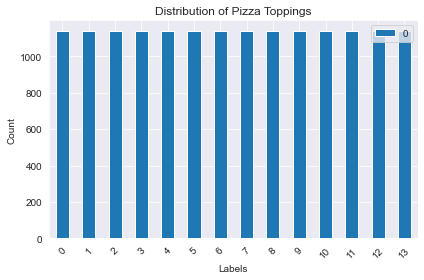

In [86]:
distribution = balance_df.loc[indices].sum().to_numpy()
non_used_df = balance_df.loc[random.sample(list(set(balance_df.index).difference(set(indices))), len(balance_df)-len(np.unique(indices)))]
max_height = distribution.max()
for index in non_used_df.index:
    # First try to fill the lower observations with pizzas from the train set which are not already used
    if all((distribution+non_used_df.loc[index].to_numpy())<=max_height):
        indices.append(index)
        distribution += non_used_df.loc[index].to_numpy()

while any(distribution!=max_height):
    # Then fill with dupes from the entire dataframe
    ingredient = random.sample(balance_df.columns[distribution!=max_height].to_list(),1)[0] 
    if all((distribution+balance_df[balance_df[ingredient]==1].to_numpy().sum(axis = 0))<=max_height):
        indices += balance_df[balance_df[ingredient]==1].index.to_list()
        distribution += balance_df[balance_df[ingredient]==1].to_numpy().sum(axis = 0)
    
    else:
        index = random.sample(balance_df[balance_df[ingredient]==1].index.to_list(), 1)[0]
    
        while any((distribution+balance_df.loc[index].to_numpy())>max_height):
            index = random.sample(balance_df[balance_df[ingredient]==1].index.to_list(), 1)[0]
        
        indices.append(index)
        distribution += balance_df.loc[index].to_numpy()
      
plt.figure(figsize=(10, 6))
pd.DataFrame(distribution).plot(kind="bar")
plt.title("Distribution of Pizza Toppings")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [87]:
p_i = np.array((train_df.drop(columns=['image_name', 'plain']).loc[indices].sum(axis=0) / len(indices)).tolist())
efdid = sum(p_i * ((np.log(p_i) - np.log(1 / len(p_i))) ** 2))
efdid

0.17299664227406603

In [88]:
p_i

array([0.10908047, 0.10908047, 0.10908047, 0.10908047, 0.10908047,
       0.10908047, 0.10908047, 0.10908047, 0.10908047, 0.10908047,
       0.10908047, 0.10908047, 0.10908047])

In [89]:
train_df.drop(columns=['image_name', 'plain']).loc[indices].sum(axis=0) 

Pepperoni       1140
Bacon           1140
Mushrooms       1140
Onions          1140
Peppers         1140
Black olives    1140
Tomatoes        1140
Spinach         1140
Fresh basil     1140
Arugula         1140
Broccoli        1140
Corn            1140
Pineapple       1140
dtype: int64

In [232]:
from collections import Counter
Counter(indices).most_common()

[(2724, 46),
 (6795, 45),
 (473, 43),
 (5113, 42),
 (2899, 38),
 (5718, 38),
 (4779, 38),
 (8953, 37),
 (7406, 37),
 (8946, 37),
 (8790, 37),
 (2006, 36),
 (1735, 36),
 (9074, 35),
 (2521, 35),
 (2496, 35),
 (7165, 34),
 (1938, 34),
 (8781, 33),
 (299, 33),
 (7911, 33),
 (8294, 32),
 (7851, 31),
 (4506, 31),
 (7225, 30),
 (2697, 30),
 (6694, 30),
 (72, 30),
 (7205, 29),
 (550, 29),
 (8281, 27),
 (9062, 27),
 (647, 27),
 (6968, 26),
 (7383, 26),
 (5455, 26),
 (6439, 25),
 (7865, 24),
 (369, 24),
 (713, 24),
 (1387, 24),
 (4675, 23),
 (483, 20),
 (1469, 20),
 (1446, 19),
 (1112, 18),
 (2877, 18),
 (1495, 18),
 (2952, 17),
 (5494, 17),
 (8427, 17),
 (5849, 16),
 (7331, 16),
 (6202, 16),
 (1578, 16),
 (6262, 15),
 (5098, 15),
 (8497, 15),
 (5325, 15),
 (1397, 15),
 (1773, 15),
 (6668, 15),
 (7346, 15),
 (7598, 15),
 (4299, 15),
 (2415, 15),
 (6685, 14),
 (319, 14),
 (2764, 14),
 (8791, 14),
 (137, 14),
 (8980, 14),
 (57, 14),
 (4719, 14),
 (7253, 14),
 (6605, 14),
 (1995, 13),
 (2468, 13),

In [228]:
balance_df[balance_df['Pineapple']==1].to_numpy().sum(axis = 0)

array([ 7,  2,  4, 18,  9,  4,  9,  0,  2,  0,  0,  0, 60,  0],
      dtype=int64)

In [234]:
train_df.loc[2724]

Pepperoni                                      0
Bacon                                          0
Mushrooms                                      0
Onions                                         0
Peppers                                        0
Black olives                                   0
Tomatoes                                       0
Spinach                                        1
Fresh basil                                    0
Arugula                                        1
Broccoli                                       1
Corn                                           0
Pineapple                                      0
plain                                          0
image_name      data\pizza_data\images\02725.jpg
Name: 2724, dtype: object

<AxesSubplot:>

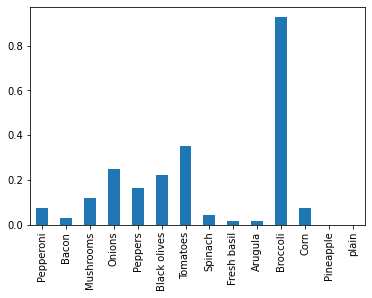

In [236]:
(train_df[train_df['Broccoli']==1].drop(columns = 'image_name').sum()/68).plot(kind="bar")

In [188]:
all((distribution+non_used_df.loc[1988].to_numpy())<=max_height)

True

In [150]:
label = 'Pepperoni'
mults_df.loc[label,0]//len(train_df[train_df[label] == 1].index)
train_df[train_df[label] == 1].index.tolist

<bound method IndexOpsMixin.tolist of Int64Index([1121, 3506, 1498, 6408, 5682, 6136, 9131, 1024, 8006,   53,
            ...
            4732,  784, 8239, 5339, 2404, 6423,  257, 2997, 1176, 3516],
           dtype='int64', length=1613)>

In [131]:
mults_df.loc['Pepperoni',0]

287.0

In [122]:
1000 // len(train_df[train_df['Spinach'] == 1].index)

2

In [125]:
1000 % len(train_df[train_df['Spinach'] == 1].index)

324

In [126]:
324+ 2*len(train_df[train_df['Spinach'] == 1].index)

1000

In [123]:
2*[0,3,4,5]

[0, 3, 4, 5, 0, 3, 4, 5]